# Network analysis in Senegal

### Objectives
    1)	Use measures of road-based accessibility to identify road segments that, if rehabilitated, would improve agricultural market activities in Senegal, including during flood conditions.
    2)	Gain a better understanding of the accessibility, connectivity, and criticality of roads in Senegal in relationship to agricultural origins, processing & transfer sites, and markets.

To this end, the team will develop an accessibility model which measures the travel time from sites of agricultural production to their nearest populated areas, processing centers, and markets. 

### Datasets for analysis
#### ORIGIN
    1) agriculture: MapSPAM 2017. Measuring value in international dollars.
    2) agriculture: UMD Land Cover 2019 30m. Assign MapSPAM value onto land cover cropland class for more precise origin information.
    3) population: WorldPop 2020, UN-adjusted.
    4) settlement extent: GRID3 2020.
#### DESTINATION
    4) markets: derived from WorldPop 2020 and GRID3 2020 urban clusters.
    5) agricultural processing hubs: to be acquired.
#### TRAVEL ROUTE
    6) roads: OpenStreetMap, July 2021.
    7) elevation: 
#### OBSTACLE
    8) flood: FATHOM. 1-in-10, 20, and 50 year flood return periods. 
#### INTERVENTION
    9) upcoming road projects: AGEROUTE interventions separate from the World Bank-financed project
    10) targeted road projects: critical road segments identified by this accessibility model's baseline outputs


### Model design
#### Basic formula: 
    (a) Off-road driving time from origin to closest road node
    +
    (b) Driving time from road node in (a) to a destination (closeness measured by road segments speeds)

#### Model origin & destination (OD) sets:
    A)	Travel time from an area that has agricultural value/potential to the nearest processing hub (if provided).
    B)	Travel time from an area that has agricultural value/potential to the nearest larger settlement, (“larger” settlement identified using a case-appropriate population metric to be determined).
    C)	Travel time from an area that has agricultural value/potential to the nearest market.
    D)	Travel time from all settlements to the nearest market.
    E)	Travel time from larger settlements to the nearest market.

#### Before/after scenarios for each OD set:
    1)	Pre-project, baseline weather: No inclement weather. Road network status as of November 2021.
    2)	Pre-project, flood: 1-in-10, 1-in-20 and 1-in-50 year flood return period. Road network status as of November 2021.
    3)	Post-project, baseline weather: No inclement weather. Road network status if X number of critical road segments to high-value areas are protected (i.e., their travel times reduced).
    4)	Post-project, flood: 1-in-10 year flood return period. Road network status if X number of critical road segments to high-value areas are protected (i.e., their travel times reduced).

#### Notes:
    --Destinations are expected to be proximal to the road network, so no measure is taken between road and destination.
    --All travel times will be assigned to each model variation’s point of origin; the aggregation up to admin areas is possible if desired.
    --Obstacles & interventions modify the road segment speeds. Basic formula is then applied to the modified road network.


### Prep workspace

In [1]:
import os, sys
GISFolder = os.getcwd()
GISFolder

'C:\\Users\\wb527163\\GEO-Cdrive-Grace'

In [2]:
# Note: needed to reinstall rtree due to geopandas import error. Did so in the console. 
# conda install -c conda-forge rtree=0.9.3

In [3]:
# load and filter osm network (step 1)
import geopandas as gpd
from geopandas import GeoDataFrame
import pandas as pd
import time
sys.path.append(r"C:\Users\wb527163\.conda\envs\geo\GOSTnets-master")
import GOSTnets as gn

In [4]:
import networkx as nx
import osmnx as ox
import numpy as np
import rasterio as rt
import shapely
from shapely.geometry import Point, box
from shapely.ops import unary_union
from shapely.wkt import loads
from shapely import wkt
from shapely.geometry import LineString, MultiLineString, Point
import peartree

In [5]:
#### Might not use these
import fiona
from osgeo import gdal
import importlib
import matplotlib.pyplot as plt
import subprocess, glob

In [6]:
pth = os.path.join(GISFolder, "SEN-Cdrive") # Personal folder system for running model.
pth

'C:\\Users\\wb527163\\GEO-Cdrive-Grace\\SEN-Cdrive'

In [7]:
out_pth = os.path.join(GISFolder, "SEN-Cdrive\outputs") # For storing intermediate outputs from the model.
out_pth

'C:\\Users\\wb527163\\GEO-Cdrive-Grace\\SEN-Cdrive\\outputs'

In [8]:
team_pth = 'R:\\SEN\\GEO' # This is where the unmodified input data is stored. Finalized outputs also housed here.
team_pth

'R:\\SEN\\GEO'

### Prepare and clean the data

In [ ]:
# Notes:
# OSM road network is in WGS84. Projected each dataset to match.
# Starting as CSV (dataframe) and deriving geometry from there tends to avoid read errors.

#### Get centroids of polygonal origins and destinations.

In [9]:
# High density areas, the proxy for markets
HDurban_extents = gpd.read_file("R:\SEN\GEO\Team\Projects\SEN_WPR_Urban\SEN_WPR_Urban.gdb", layer="SEN_urbanonly")
HDurban_extents.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   mgrs_code        319 non-null    object  
 1   type             319 non-null    object  
 2   AREA_GEO         319 non-null    float64 
 3   SUM              318 non-null    float64 
 4   Total_DriveTime  312 non-null    float64 
 5   WP_dens          319 non-null    float64 
 6   urb              319 non-null    object  
 7   hd_urb           319 non-null    object  
 8   Urb_class        319 non-null    int64   
 9   Shape_Length     319 non-null    float64 
 10  Shape_Area       319 non-null    float64 
 11  geometry         319 non-null    geometry
dtypes: float64(6), geometry(1), int64(1), object(4)
memory usage: 30.0+ KB


In [10]:
HDurban_extents = HDurban_extents[HDurban_extents['hd_urb']=="1"] # We only want high density urban areas.
HDurban_extents

,mgrs_code,type,AREA_GEO,SUM,Total_DriveTime,WP_dens,urb,hd_urb,Urb_class,Shape_Length,Shape_Area,geometry
1,28PCU6189_01,bua,27.151434,1.860466e+05,0.000000,6852.183502,1,1,2,0.671746,2.258828e-03,"MULTIPOLYGON (((-16.26476 12.53975, -16.26457 ..."
8,28PEV0625_01,bua,25.799549,1.064198e+05,0.000000,4124.872441,1,1,2,0.718941,2.149259e-03,"MULTIPOLYGON (((-14.93056 12.91749, -14.93087 ..."
37,28PBA8597_01,bua,81.242354,3.382677e+05,0.000000,4163.686114,1,1,2,2.303639,6.813610e-03,"MULTIPOLYGON (((-17.03153 14.48851, -17.03169 ..."
47,28PCA8365_01,bua,42.134069,2.755403e+05,0.000000,6539.609258,1,1,2,1.070058,3.528274e-03,"MULTIPOLYGON (((-16.05918 14.18057, -16.05899 ..."
56,28PDA4058_01,bua,11.123881,5.186398e+04,0.000000,4662.399756,1,1,2,0.298223,9.311211e-04,"MULTIPOLYGON (((-15.56851 14.09515, -15.56830 ..."
75,28PBB9234_01,bua,53.453391,2.911360e+05,0.000000,5446.539082,1,1,2,1.468618,4.489114e-03,"MULTIPOLYGON (((-16.90709 14.82055, -16.90657 ..."
76,28PBB4632_01,bua,226.850348,3.637718e+06,0.000000,16035.762110,1,1,2,4.771359,1.905124e-02,"MULTIPOLYGON (((-17.24205 14.83253, -17.24242 ..."
80,28PCB0453_01,bua,19.580942,8.712281e+04,0.000000,4449.367491,1,1,2,0.611345,1.645460e-03,"MULTIPOLYGON (((-16.79483 14.96199, -16.79527 ..."
84,28PCB6720_01,bua,23.634834,1.342721e+05,0.000000,5681.109779,1,1,2,0.689064,1.983306e-03,"MULTIPOLYGON (((-16.20153 14.66636, -16.20230 ..."
98,28PDB0443_01,bua,196.802191,9.490037e+05,0.000000,2575.818720,1,1,2,3.094788,1.653195e-02,"MULTIPOLYGON (((-15.88585 14.92136, -15.88630 ..."


In [ ]:
# Settlement areas. Probably won't use for this analysis.
# ssa_extents = gpd.read_file("R:\SEN\GEO\Settlement_Extents\GRID3_SEN_settlement_extents_20200625.gdb", layer="ssa_extents")
# ssa_extents.info()

In [11]:
# Hamlets are the most dispersed populated areas
hamlet_extents = gpd.read_file("R:\SEN\GEO\Settlement_Extents\GRID3_SEN_settlement_extents_20200625.gdb", layer="hamlet_extents")
hamlet_extents.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 125886 entries, 0 to 125885
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   mgrs_code     125886 non-null  object  
 1   type          125886 non-null  object  
 2   GlobalID      125886 non-null  object  
 3   Shape_Length  125886 non-null  float64 
 4   Shape_Area    125886 non-null  float64 
 5   geometry      125886 non-null  geometry
dtypes: float64(2), geometry(1), object(3)
memory usage: 5.8+ MB


In [12]:
# Reproject to projected CRS (UTM 28N) to allow for accurate centroid measure.
HDurban_extents = HDurban_extents.to_crs("EPSG:31028")
hamlet_extents = hamlet_extents.to_crs("EPSG:31028")
HDurban_extents.crs

<Projected CRS: EPSG:31028>
Name: Yoff / UTM zone 28N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Senegal - onshore and offshore.
- bounds: (-20.22, 10.64, -11.36, 16.7)
Coordinate Operation:
- name: UTM zone 28N
- method: Transverse Mercator
Datum: Yoff
- Ellipsoid: Clarke 1880 (IGN)
- Prime Meridian: Greenwich

In [13]:
HDurban_extents['centroid'] = HDurban_extents['geometry'].centroid
hamlet_extents['centroid'] = hamlet_extents['geometry'].centroid
HDurban_extents

,mgrs_code,type,AREA_GEO,SUM,Total_DriveTime,WP_dens,urb,hd_urb,Urb_class,Shape_Length,Shape_Area,geometry,centroid
1,28PCU6189_01,bua,27.151434,1.860466e+05,0.000000,6852.183502,1,1,2,0.671746,2.258828e-03,"MULTIPOLYGON (((362412.970 1386488.242, 362433...",POINT (361509.129 1388994.206)
8,28PEV0625_01,bua,25.799549,1.064198e+05,0.000000,4124.872441,1,1,2,0.718941,2.149259e-03,"MULTIPOLYGON (((507356.934 1427932.037, 507323...",POINT (506747.230 1425130.889)
37,28PBA8597_01,bua,81.242354,3.382677e+05,0.000000,4163.686114,1,1,2,2.303639,6.813610e-03,"MULTIPOLYGON (((280867.529 1602646.968, 280849...",POINT (285624.016 1597820.527)
47,28PCA8365_01,bua,42.134069,2.755403e+05,0.000000,6539.609258,1,1,2,1.070058,3.528274e-03,"MULTIPOLYGON (((385525.737 1567875.561, 385546...",POINT (383686.673 1565651.339)
56,28PDA4058_01,bua,11.123881,5.186398e+04,0.000000,4662.399756,1,1,2,0.298223,9.311211e-04,"MULTIPOLYGON (((438454.842 1558243.973, 438477...",POINT (440713.609 1558821.669)
75,28PBB9234_01,bua,53.453391,2.911360e+05,0.000000,5446.539082,1,1,2,1.468618,4.489114e-03,"MULTIPOLYGON (((294593.085 1639272.644, 294649...",POINT (292503.897 1634872.377)
76,28PBB4632_01,bua,226.850348,3.637718e+06,0.000000,16035.762110,1,1,2,4.771359,1.905124e-02,"MULTIPOLYGON (((258544.937 1640932.927, 258505...",POINT (246141.315 1632142.196)
80,28PCB0453_01,bua,19.580942,8.712281e+04,0.000000,4449.367491,1,1,2,0.611345,1.645460e-03,"MULTIPOLYGON (((306803.863 1654824.280, 306756...",POINT (304382.356 1653053.029)
84,28PCB6720_01,bua,23.634834,1.342721e+05,0.000000,5681.109779,1,1,2,0.689064,1.983306e-03,"MULTIPOLYGON (((370443.395 1621689.059, 370360...",POINT (367608.395 1620305.700)
98,28PDB0443_01,bua,196.802191,9.490037e+05,0.000000,2575.818720,1,1,2,3.094788,1.653195e-02,"MULTIPOLYGON (((404549.862 1649739.323, 404502...",POINT (404318.064 1642985.675)


In [17]:
hamlet_extents

,mgrs_code,type,GlobalID,Shape_Length,Shape_Area,geometry,centroid
0,28PCU1265_01,hamlet,{ED2CCDD5-C78F-40B6-A18A-3A01B61A4998},0.004314,0.000001,"MULTIPOLYGON (((312628.929 1365556.418, 312624...",POINT (312643.659 1365626.539)
1,28PCU1365_01,hamlet,{372B104B-B208-4D14-84E2-8ABFD4D8C37A},0.009910,0.000006,"MULTIPOLYGON (((313250.671 1365704.850, 313277...",POINT (313188.766 1365540.193)
2,28PCU1365_02,hamlet,{D03C2B85-5F35-4EE8-8346-B83494628F26},0.003754,0.000001,"MULTIPOLYGON (((313476.964 1365931.550, 313477...",POINT (313473.832 1365869.571)
3,28PCU1566_01,hamlet,{5EAFF1C3-6EE5-4F96-99FC-78F924454480},0.004401,0.000002,"MULTIPOLYGON (((314918.465 1366356.355, 314916...",POINT (314845.335 1366381.262)
4,28PCU1566_02,hamlet,{1D6A9E17-0D49-446D-A23B-7A47B155DC64},0.005357,0.000002,"MULTIPOLYGON (((315137.148 1366435.601, 315133...",POINT (315118.245 1366514.411)
...,...,...,...,...,...,...,...
125881,28QED6412_03,hamlet,{5555A010-36B2-47D2-96C4-BDD1E59111ED},0.005397,0.000002,"MULTIPOLYGON (((564064.948 1812494.457, 564061...",POINT (564125.180 1812551.470)
125882,28QED6413_03,hamlet,{20205A44-8B9D-4FCE-B14C-53826594DB5A},0.003610,0.000001,"MULTIPOLYGON (((564160.192 1813891.072, 564164...",POINT (564159.267 1813827.524)
125883,28QED6413_04,hamlet,{AC6A169C-FD0E-4DF6-BDAB-B69FBD04BFAF},0.015471,0.000008,"MULTIPOLYGON (((563763.297 1813785.773, 563816...",POINT (563851.024 1813674.633)
125884,28QED6424_03,hamlet,{51593C65-B268-4BA1-8212-E43232C021FF},0.003883,0.000001,"MULTIPOLYGON (((564217.554 1823899.891, 564214...",POINT (564260.335 1823947.187)


#### Prefer it in X,Y columns, so here we're extracting the coordinates from the centroid geometry column:

In [14]:
HDurban_extents.to_csv(os.path.join(out_pth, 'HDurban_extents.csv'))
HDurban_pt = os.path.join(out_pth, "HDurban_extents.csv")
HDurban_pt = pd.read_csv(HDurban_pt)
crs = {'init': 'epsg:31028'} 
HDurban_pt['centroid'] = HDurban_pt['centroid'].apply(wkt.loads) # It wasn't reading the centroid column as geometry at first.
HDurban_pt = HDurban_pt.drop(columns=['geometry']) # We need to get rid of the old geometry variables as soon as possible to avoid any interference with georeferencing later on.
HDurban_pt = GeoDataFrame(HDurban_pt, crs=crs, geometry='centroid') 
HDurban_pt.to_file(driver='ESRI Shapefile', filename='SEN-Cdrive/outputs/HDurban_pt.shp') 
HDurban_pt

C:\Users\wb527163\.conda\envs\geo\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\wb527163\AppData\Local\Temp/ipykernel_3792/1924782670.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  HDurban_pt.to_file(driver='ESRI Shapefile', filename='SEN-Cdrive/outputs/HDurban_pt.shp')


,Unnamed: 0,mgrs_code,type,AREA_GEO,SUM,Total_DriveTime,WP_dens,urb,hd_urb,Urb_class,Shape_Length,Shape_Area,centroid
0,1,28PCU6189_01,bua,27.151434,1.860466e+05,0.000000,6852.183502,1,1,2,0.671746,2.258828e-03,POINT (361509.129 1388994.206)
1,8,28PEV0625_01,bua,25.799549,1.064198e+05,0.000000,4124.872441,1,1,2,0.718941,2.149259e-03,POINT (506747.230 1425130.889)
2,37,28PBA8597_01,bua,81.242354,3.382677e+05,0.000000,4163.686114,1,1,2,2.303639,6.813610e-03,POINT (285624.016 1597820.527)
3,47,28PCA8365_01,bua,42.134069,2.755403e+05,0.000000,6539.609258,1,1,2,1.070058,3.528274e-03,POINT (383686.673 1565651.339)
4,56,28PDA4058_01,bua,11.123881,5.186398e+04,0.000000,4662.399756,1,1,2,0.298223,9.311211e-04,POINT (440713.609 1558821.669)
5,75,28PBB9234_01,bua,53.453391,2.911360e+05,0.000000,5446.539082,1,1,2,1.468618,4.489114e-03,POINT (292503.897 1634872.377)
6,76,28PBB4632_01,bua,226.850348,3.637718e+06,0.000000,16035.762110,1,1,2,4.771359,1.905124e-02,POINT (246141.315 1632142.196)
7,80,28PCB0453_01,bua,19.580942,8.712281e+04,0.000000,4449.367491,1,1,2,0.611345,1.645460e-03,POINT (304382.356 1653053.029)
8,84,28PCB6720_01,bua,23.634834,1.342721e+05,0.000000,5681.109779,1,1,2,0.689064,1.983306e-03,POINT (367608.395 1620305.700)
9,98,28PDB0443_01,bua,196.802191,9.490037e+05,0.000000,2575.818720,1,1,2,3.094788,1.653195e-02,POINT (404318.064 1642985.675)


In [26]:
hamlet_extents.to_csv(os.path.join(out_pth, 'hamlet_extents.csv'))
hamlet_pt = os.path.join(out_pth, "hamlet_extents.csv")
hamlet_pt = pd.read_csv(hamlet_pt)
crs = {'init': 'epsg:31028'} 
hamlet_pt['centroid'] = hamlet_pt['centroid'].apply(wkt.loads)
hamlet_pt = hamlet_pt.drop(columns=['geometry']) # We need to get rid of the old geometry variables as soon as possible to avoid any interference with georeferencing later on.
hamlet_pt = GeoDataFrame(hamlet_pt, crs=crs, geometry='centroid') 
hamlet_pt.to_file(driver='ESRI Shapefile', filename='SEN-Cdrive/outputs/hamlet_pt.shp') 
hamlet_pt

C:\Users\wb527163\.conda\envs\geo\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,Unnamed: 0,mgrs_code,type,GlobalID,Shape_Length,Shape_Area,centroid
0,0,28PCU1265_01,hamlet,{ED2CCDD5-C78F-40B6-A18A-3A01B61A4998},0.004314,0.000001,POINT (312643.659 1365626.539)
1,1,28PCU1365_01,hamlet,{372B104B-B208-4D14-84E2-8ABFD4D8C37A},0.009910,0.000006,POINT (313188.766 1365540.193)
2,2,28PCU1365_02,hamlet,{D03C2B85-5F35-4EE8-8346-B83494628F26},0.003754,0.000001,POINT (313473.832 1365869.571)
3,3,28PCU1566_01,hamlet,{5EAFF1C3-6EE5-4F96-99FC-78F924454480},0.004401,0.000002,POINT (314845.335 1366381.262)
4,4,28PCU1566_02,hamlet,{1D6A9E17-0D49-446D-A23B-7A47B155DC64},0.005357,0.000002,POINT (315118.245 1366514.411)
...,...,...,...,...,...,...,...
125881,125881,28QED6412_03,hamlet,{5555A010-36B2-47D2-96C4-BDD1E59111ED},0.005397,0.000002,POINT (564125.180 1812551.470)
125882,125882,28QED6413_03,hamlet,{20205A44-8B9D-4FCE-B14C-53826594DB5A},0.003610,0.000001,POINT (564159.267 1813827.524)
125883,125883,28QED6413_04,hamlet,{AC6A169C-FD0E-4DF6-BDAB-B69FBD04BFAF},0.015471,0.000008,POINT (563851.024 1813674.633)
125884,125884,28QED6424_03,hamlet,{51593C65-B268-4BA1-8212-E43232C021FF},0.003883,0.000001,POINT (564260.335 1823947.187)


In [15]:
# The road graph will be in WGS84, so we'll start with that.
HDurban_pt = HDurban_pt.to_crs("EPSG:4326")
hamlet_pt = hamlet_pt.to_crs("EPSG:4326")

In [29]:
HDurban_pt.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Unnamed: 0       319 non-null    int64   
 1   mgrs_code        319 non-null    object  
 2   type             319 non-null    object  
 3   AREA_GEO         319 non-null    float64 
 4   SUM              318 non-null    float64 
 5   Total_DriveTime  312 non-null    float64 
 6   WP_dens          319 non-null    float64 
 7   urb              319 non-null    int64   
 8   hd_urb           319 non-null    int64   
 9   Urb_class        319 non-null    int64   
 10  Shape_Length     319 non-null    float64 
 11  Shape_Area       319 non-null    float64 
 12  centroid         319 non-null    geometry
dtypes: float64(6), geometry(1), int64(4), object(2)
memory usage: 32.5+ KB


In [30]:
hamlet_pt.head()

,Unnamed: 0,mgrs_code,type,GlobalID,Shape_Length,Shape_Area,centroid
0,0,28PCU1265_01,hamlet,{ED2CCDD5-C78F-40B6-A18A-3A01B61A4998},0.004314,0.000001,POINT (-16.72147 12.34864)
1,1,28PCU1365_01,hamlet,{372B104B-B208-4D14-84E2-8ABFD4D8C37A},0.009910,0.000006,POINT (-16.71646 12.34789)
2,2,28PCU1365_02,hamlet,{D03C2B85-5F35-4EE8-8346-B83494628F26},0.003754,0.000001,POINT (-16.71386 12.35088)
3,3,28PCU1566_01,hamlet,{5EAFF1C3-6EE5-4F96-99FC-78F924454480},0.004401,0.000002,POINT (-16.70128 12.35559)
4,4,28PCU1566_02,hamlet,{1D6A9E17-0D49-446D-A23B-7A47B155DC64},0.005357,0.000002,POINT (-16.69877 12.35680)


In [12]:
# Earlier, created an approximate bounding area which includes parts of neighboring countries and all of The Gambia.
aoi = gpd.read_file("R:/SEN/GEO/Roads/bounding_senegam_buffered.shp") # AOI = Area of Interest
print(aoi)

   id       bound                                           geometry
0   0  senegambia  POLYGON ((-16.79591 16.13764, -16.44946 16.908...


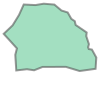

In [13]:
bound = aoi.geometry.iloc[0]
bound # Check that it's shaped like Senegal & Gambia.

In [18]:
# Check to confirm each file so far is the same coordinate system.
HDurban_pt.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Get driving network from OSM.
Travel measured in length (meters).

In [9]:
networkType = 'drive'

In [10]:
?ox.graph_from_polygon

In [15]:
gDrive = ox.graph_from_polygon(bound, network_type= 'drive')
# Note: length is measured in meters.
# Took approximately 30 min.

C:\Users\wb527163\.conda\envs\geo\lib\site-packages\osmnx-1.1.1-py3.8.egg\osmnx\utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
C:\Users\wb527163\.conda\envs\geo\lib\site-packages\osmnx-1.1.1-py3.8.egg\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
C:\Users\wb527163\.conda\envs\geo\lib\site-packages\osmnx-1.1.1-py3.8.egg\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


In [16]:
# Save all road nodes (points on the road) to file.
gDrive_node_gdf = gn.node_gdf_from_graph(gDrive)
gDrive_node_gdf.to_csv(os.path.join(out_pth, 'drive_dist_node.csv'))

In [24]:
?gn.convert_network_to_time

In [17]:
speed_dict = {
                'residential': 40,  # kmph
                'primary': 80, 
                'primary_link':60,
                'motorway':80,
                'motorway_link': 60,
                'trunk': 80,
                'trunk_link':60,
                'secondary': 70, 
                'secondary_link':50,
                'tertiary':60,
                'tertiary_link': 40,
                'unclassified':50, 
                'road':50,
                'crossing':40,
                'living_street':40,
                'construction':30,
                'track':25,
                'footway':4.5,
                'path':4.5,
                'pedestrian':4.5
                }
gTime = gn.convert_network_to_time(gDrive, distance_tag = 'length', graph_type = 'drive', speed_dict = speed_dict)
# Note: time is in seconds.

#### Save road nodes and road edges to file. Edges contains time measure

In [18]:
edges = gn.edge_gdf_from_graph(gTime)
nodes = gn.node_gdf_from_graph(gTime)

In [19]:
edges.info() # 1,111,798 edges

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1111798 entries, 0 to 1111797
Data columns (total 19 columns):
 #   Column    Non-Null Count    Dtype   
---  ------    --------------    -----   
 0   stnode    1111798 non-null  int64   
 1   endnode   1111798 non-null  int64   
 2   length    1111798 non-null  float64 
 3   time      1111798 non-null  float64 
 4   area      8 non-null        object  
 5   width     226 non-null      object  
 6   highway   1111798 non-null  object  
 7   mode      1111798 non-null  object  
 8   ref       26857 non-null    object  
 9   bridge    1623 non-null     object  
 10  lanes     61592 non-null    object  
 11  tunnel    80 non-null       object  
 12  junction  1945 non-null     object  
 13  oneway    1111798 non-null  bool    
 14  maxspeed  19114 non-null    object  
 15  access    9343 non-null     object  
 16  name      39209 non-null    object  
 17  osmid     1111798 non-null  object  
 18  geometry  1111798 non-null  geomet

In [20]:
nodes.info() # 368,843 nodes

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 368843 entries, 0 to 368842
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   node_ID       368843 non-null  int64   
 1   y             368843 non-null  float64 
 2   x             368843 non-null  float64 
 3   street_count  368843 non-null  int64   
 4   highway       192 non-null     object  
 5   ref           42 non-null      object  
 6   geometry      368843 non-null  geometry
dtypes: float64(2), geometry(1), int64(2), object(2)
memory usage: 22.5+ MB


In [21]:
edges.to_csv(os.path.join(out_pth, 'drive_time_edge.csv'))
nodes.to_csv(os.path.join(out_pth, 'drive_time_node.csv'))

In [25]:
edges.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [22]:
# Save a pickle of the graph with the time measure for easy recall.
gn.save(gTime, 'SEN-Cdrive/gTime', '', edges = False, nodes = False)

In [28]:
crs = 'epsg:4326'
nodes = GeoDataFrame(nodes, crs=crs, geometry='geometry') 
nodes.to_file(driver='ESRI Shapefile', filename='SEN-Cdrive/drive_time_nodes.shp') 
nodes

C:\Users\wb527163\AppData\Local\Temp/ipykernel_20828/3077283279.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nodes.to_file(driver='ESRI Shapefile', filename='SEN-Cdrive/drive_time_nodes.shp')


,node_ID,y,x,street_count,highway,ref,geometry
0,358284990,12.381189,-12.323471,3,NaN,NaN,POINT (-12.32347 12.38119)
1,358285037,12.534741,-12.267195,3,NaN,NaN,POINT (-12.26720 12.53474)
2,496429117,12.067253,-12.293792,4,NaN,NaN,POINT (-12.29379 12.06725)
3,670104023,12.411030,-12.282907,3,NaN,NaN,POINT (-12.28291 12.41103)
4,670104201,12.512258,-12.360983,3,NaN,NaN,POINT (-12.36098 12.51226)
...,...,...,...,...,...,...,...
368838,9051042249,14.744381,-17.503115,3,NaN,NaN,POINT (-17.50312 14.74438)
368839,9165563646,14.723645,-17.480974,3,NaN,NaN,POINT (-17.48097 14.72365)
368840,9165563649,14.723713,-17.481007,3,NaN,NaN,POINT (-17.48101 14.72371)
368841,9165665131,14.751656,-17.506953,3,NaN,NaN,POINT (-17.50695 14.75166)


In [27]:
edges = os.path.join(pth, "drive_time_edge.csv")
edges = pd.read_csv(edges)
crs = 'epsg:4326'
edges = GeoDataFrame(edges, crs=crs, geometry='geometry') 
edges.to_file(driver='ESRI Shapefile', filename='SEN-Cdrive/drive_time_edge.shp') 
edges

C:\Users\wb527163\.conda\envs\geo\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5,6,9,10,11,12,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


TypeError: Input must be valid geometry objects: LINESTRING (-12.3234708 12.3811895, -12.3236829 12.3814036, -12.3237757 12.3815281, -12.3238117 12.3816787, -12.3238136 12.3817306)

In [23]:
edges.to_file(driver='ESRI Shapefile', filename='SEN-Cdrive/drive_time_edge.shp') 
nodes.to_file(driver='ESRI Shapefile', filename='SEN-Cdrive/drive_time_node.shp') 

ValueError: Invalid field type <class 'list'>

### Origins and destinations

Measure distance from origin/destination to nearest node and save to file.

In [19]:
#%% If starting new session, reload graph from file
gTime = nx.read_gpickle("SEN-Cdrive/outputs/gTime.pickle")
HDurban_pt = gpd.read_file("SEN-Cdrive/outputs/HDurban_pt.shp")
hamlet_pt = gpd.read_file("SEN-Cdrive/outputs/hamlet_pt.shp")
HDurban_pt = HDurban_pt.to_crs("EPSG:4326")
hamlet_pt = hamlet_pt.to_crs("EPSG:4326")
HDurban_pt.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Unnamed_ 0  58 non-null     int64   
 1   mgrs_code   58 non-null     object  
 2   type        58 non-null     object  
 3   AREA_GEO    58 non-null     float64 
 4   SUM         58 non-null     float64 
 5   Total_Driv  57 non-null     float64 
 6   WP_dens     58 non-null     float64 
 7   urb         58 non-null     int64   
 8   hd_urb      58 non-null     int64   
 9   Urb_class   58 non-null     int64   
 10  Shape_Leng  58 non-null     float64 
 11  Shape_Area  58 non-null     float64 
 12  geometry    58 non-null     geometry
dtypes: float64(6), geometry(1), int64(4), object(2)
memory usage: 6.0+ KB


In [20]:
HDurban_pt.dtypes

Unnamed_ 0       int64
mgrs_code       object
type            object
AREA_GEO       float64
SUM            float64
Total_Driv     float64
WP_dens        float64
urb              int64
hd_urb           int64
Urb_class        int64
Shape_Leng     float64
Shape_Area     float64
geometry      geometry
dtype: object

In [39]:
?gn.pandana_snap_c

In [21]:
HDurban_snap = gn.pandana_snap_c(gTime, HDurban_pt, source_crs = 'epsg:4326', target_crs = 'epsg:31028', add_dist_to_node_col = True)
HDurban_snap.to_csv('SEN-Cdrive/outputs/HDurban_snap.csv', index=True)
# Finished within a minute.
HDurban_snap.head()

,Unnamed_ 0,mgrs_code,type,AREA_GEO,SUM,Total_Driv,WP_dens,urb,hd_urb,Urb_class,Shape_Leng,Shape_Area,geometry,NN,NN_dist
0,1,28PCU6189_01,bua,27.151434,186046.609754,0.0,6852.183502,1,1,2,0.671746,0.002259,POINT (-16.27319 12.56237),2119246531,39.014876
1,8,28PEV0625_01,bua,25.799549,106419.847629,0.0,4124.872441,1,1,2,0.718941,0.002149,POINT (-14.93619 12.89216),6029312286,126.148648
2,37,28PBA8597_01,bua,81.242354,338267.661530,0.0,4163.686114,1,1,2,2.303639,0.006814,POINT (-16.98703 14.44528),4998093094,55.383696
3,47,28PCA8365_01,bua,42.134069,275540.348418,0.0,6539.609258,1,1,2,1.070058,0.003528,POINT (-16.07613 14.16038),2201506815,55.754910
4,56,28PDA4058_01,bua,11.123881,51863.978671,0.0,4662.399756,1,1,2,0.298223,0.000931,POINT (-15.54760 14.10042),3474499811,66.927870


In [43]:
hamlet_snap = gn.pandana_snap_c(gTime, hamlet_pt, source_crs = 'epsg:4326', target_crs = 'epsg:31028', add_dist_to_node_col = True)
hamlet_snap.to_csv('SEN-Cdrive/outputs/hamlet_snap.csv', index=True)
hamlet_snap.head()

,Unnamed_ 0,mgrs_code,type,GlobalID,Shape_Leng,Shape_Area,geometry,NN,NN_dist
0,0,28PCU1265_01,hamlet,{ED2CCDD5-C78F-40B6-A18A-3A01B61A4998},0.004314,0.000001,POINT (-16.72147 12.34864),7761872879,396.520984
1,1,28PCU1365_01,hamlet,{372B104B-B208-4D14-84E2-8ABFD4D8C37A},0.009910,0.000006,POINT (-16.71646 12.34789),7761872860,918.665696
2,2,28PCU1365_02,hamlet,{D03C2B85-5F35-4EE8-8346-B83494628F26},0.003754,0.000001,POINT (-16.71386 12.35088),7761872847,952.759215
3,3,28PCU1566_01,hamlet,{5EAFF1C3-6EE5-4F96-99FC-78F924454480},0.004401,0.000002,POINT (-16.70128 12.35559),7761872847,1923.779554
4,4,28PCU1566_02,hamlet,{1D6A9E17-0D49-446D-A23B-7A47B155DC64},0.005357,0.000002,POINT (-16.69877 12.35680),7761872847,2181.254121


### Create travel time values for the road nodes nearest to each service.

Using calculate_OD.

In [22]:
# If starting a new session, load from file.
HDurban_snap = os.path.join(out_pth, "HDurban_snap.csv")
HDurban_snap = pd.read_csv(HDurban_snap)
hamlet_snap = os.path.join(out_pth, "hamlet_snap.csv")
hamlet_snap = pd.read_csv(hamlet_snap)
gTime = nx.read_gpickle("SEN-Cdrive/outputs/gTime.pickle")

In [23]:
# We only need to find the origin-destination pairs for nodes closest to the origins and services,
# and some nodes will be the nearest for more than one service (and definitely for multiple origins).
origins = list(hamlet_snap.NN.unique())

In [ ]:
nodes_list = list(nodes.NN.unique())

In [24]:
list_HDurban = list(HDurban_snap.NN.unique()) 
dests = list_HDurban

# If more than one set of destinations, you can combine the sets to go into a single OD matrix using this code:
# list_ssa = list(ssa_snap.NN.unique()) 
# destslist = list_HDurban + list_ssa
# dests = list(set(destslist))

In [25]:
len(origins) # 23108 unique nearest nodes (average of 5 origins per node).

23108

In [26]:
len(dests) # 314 unique nearest nodes. This is only 5 less than the original dataset.

57

In [27]:
fail_value = 999999999 # If there is no shortest path, the OD pair will be assigned the fail value.

In [28]:
gn.example_edge(gTime)

(358284990, 5329792501, {'osmid': 59618174, 'ref': 'D 523', 'name': 'D 523', 'highway': 'unclassified', 'oneway': False, 'length': 73.22200000000001, 'geometry': <shapely.geometry.linestring.LineString object at 0x0000027B31176EE0>, 'time': 5.271984000000001, 'mode': 'drive'})


In [29]:
?gn.calculate_OD

In [31]:
OD = gn.calculate_OD(gTime, nodes_list, dests, fail_value, weight = 'time')
# Took a few minutes.

In [32]:
OD_df = pd.DataFrame(OD, index = origins, columns = dests)

In [33]:
OD_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23108 entries, 7761872879 to 4072041221
Data columns (total 57 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   2119246531  23108 non-null  float64
 1   6029312286  23108 non-null  float64
 2   4998093094  23108 non-null  float64
 3   2201506815  23108 non-null  float64
 4   3474499811  23108 non-null  float64
 5   1697006012  23108 non-null  float64
 6   1901689169  23108 non-null  float64
 7   2846317227  23108 non-null  float64
 8   6040927878  23108 non-null  float64
 9   3449495495  23108 non-null  float64
 10  1918630462  23108 non-null  float64
 11  8972391475  23108 non-null  float64
 12  3418418812  23108 non-null  float64
 13  1983641803  23108 non-null  float64
 14  6014451367  23108 non-null  float64
 15  6027163238  23108 non-null  float64
 16  2833577864  23108 non-null  float64
 17  6040866461  23108 non-null  float64
 18  6045659374  23108 non-null  float64
 19  6038316595 

In [34]:
OD_df.tail()

,2119246531,6029312286,4998093094,2201506815,3474499811,1697006012,1901689169,2846317227,6040927878,3449495495,...,3631507838,3628686112,5427415265,6027616830,6027276894,6041227847,6048393788,299528744,8178289925,6026834850
8449983186,26016.463756,24923.205269,12437.424010,14379.991807,15482.831594,10311.808251,12611.221092,9297.181193,11559.510614,9625.515635,...,4987.389195,3613.558455,24819.525262,25109.714254,12524.656122,12330.726536,12285.977996,12258.055866,9743.866058,9811.957046
4072935008,26344.081732,25250.823245,12901.506291,14707.609783,15810.449570,10775.890532,13075.303373,9761.263474,11887.128590,9953.133611,...,5315.007171,6547.358943,25147.143238,25437.332230,12988.738403,12794.808817,12750.060277,12722.138147,10071.484034,10139.575022
4072935012,26378.117602,25284.859115,12935.542161,14741.645653,15844.485440,10809.926402,13109.339243,9795.299344,11921.164460,9987.169481,...,5349.043041,6581.394813,25181.179108,25471.368100,13022.774273,12828.844687,12784.096147,12756.174017,10105.519904,10173.610892
8558304561,27401.501872,26308.243385,13958.926431,15765.029923,16867.869710,11833.310672,14132.723513,10818.683614,12944.548730,11010.553751,...,6372.427311,7504.867182,26204.563378,26494.752370,14046.158543,13852.228957,13807.480417,13779.558287,11128.904174,11196.995162
4072041221,26415.073684,25321.815197,12836.033938,14778.601735,15881.441522,10710.418179,13009.831020,9695.791121,11958.120542,10024.125563,...,5385.999123,3887.226423,25218.135190,25508.324182,12923.266050,12729.336464,12684.587924,12656.665794,10142.475986,10210.566974


In [35]:
# Convert to minutes and save to file.
OD_min = OD_df[OD_df <fail_value] / 60
OD_min.to_csv(os.path.join(out_pth, 'fromhamlet\OD.csv'))

In [36]:
OD_min.tail(20)

,2119246531,6029312286,4998093094,2201506815,3474499811,1697006012,1901689169,2846317227,6040927878,3449495495,...,3631507838,3628686112,5427415265,6027616830,6027276894,6041227847,6048393788,299528744,8178289925,6026834850
8073203019,305.674833,287.453858,100.716801,111.733634,158.943678,65.289872,103.613419,48.379421,63.477375,72.238216,...,81.901753,134.931449,315.035854,319.872337,102.170670,98.938510,98.192701,97.727332,74.210723,75.345573
8071408643,301.727032,283.506057,106.070573,107.785833,154.995877,70.643643,108.967191,53.733192,59.529575,72.267631,...,87.255524,140.285220,311.088053,315.924537,107.524441,104.292281,103.546472,103.081103,74.240138,75.374987
3717192287,300.049891,281.828916,136.717642,106.108692,124.489355,101.290713,139.614260,84.380262,59.100672,26.867422,...,68.685053,124.512894,280.100916,284.937399,138.171510,134.939351,134.193542,133.728173,28.839930,29.974779
4186362309,500.260202,360.656559,474.885892,410.093209,362.766295,447.217908,486.561007,445.957000,388.740538,354.146702,...,376.159653,407.513459,206.287983,206.587164,479.135615,481.886097,481.140288,480.674920,363.369673,356.507061
7805596740,344.666904,326.445929,103.405022,152.027705,197.935749,67.978092,98.511433,51.138386,103.771447,126.093661,...,89.359014,124.848293,354.027926,358.864409,104.858890,86.617187,85.871378,85.386771,128.066168,129.201018
4071912759,358.022210,339.801235,126.084105,165.383010,191.954993,90.657175,128.980723,73.746724,117.126752,94.333060,...,5.174107,58.203803,347.566554,352.403037,127.537973,124.305813,123.560004,123.094636,96.305567,97.440417
6021242885,358.283148,340.062173,126.345043,165.643949,191.694054,90.918114,129.241661,74.007663,117.387690,94.072122,...,4.913169,57.942865,347.305615,352.142099,127.798912,124.566752,123.820943,123.355574,96.044629,97.179479
6026792324,363.445106,345.224131,132.156678,169.503907,187.884570,96.729749,135.053296,79.819298,122.495887,90.262637,...,4.262944,61.488179,343.496131,348.332614,133.610547,130.378387,129.632578,129.167209,92.235144,93.369994
2281084786,360.976597,342.755623,133.529347,167.035398,185.416061,98.102418,136.425965,81.191967,120.027378,87.794129,...,7.033007,62.860849,341.027623,345.864106,134.983216,131.751056,131.005247,130.539878,89.766636,90.901486
9206374054,389.888503,371.667528,235.084638,195.947304,211.706349,207.416654,246.759753,206.155746,148.939284,114.345448,...,136.358400,192.186241,304.449530,309.286013,239.334362,242.084844,241.339035,240.873666,123.568419,116.705808


In [36]:
# OD_ssa = OD_df.loc[:, list_ssa]
# OD_ssa = OD_ssa[OD_ssa < fail_value] / 60 
# OD_ssa.to_csv(os.path.join(out_pth, 'fromhamlet\OD_ssa.csv'))
# OD_ssa.tail()

,8602452847,2282284668,3319267662,2855717267,2629110597,2688809396,3789990578,3794859116,6164016987,2142496597,...,4076308493,9210412531,1504562865,8443693157,8449983204,8449983165,1990545723,9207632325,8449983219,8450698140
8449983186,489.779974,490.489051,465.537213,480.560054,464.791602,490.642296,499.221759,456.339120,477.504670,469.352061,...,19.620164,50.206813,45.711652,41.943814,0.761651,6.153029,245.093432,242.891155,5.352469,32.293983
4072935008,495.240274,495.949351,470.997512,486.020353,470.251902,496.102596,504.682058,461.799419,482.964969,474.812360,...,50.379873,99.103488,94.608327,90.840488,62.238097,62.864937,230.502881,228.300604,66.828915,73.424882
4072935012,495.807538,496.516615,471.564777,486.587618,470.819166,496.669860,505.249323,462.366684,483.532234,475.379625,...,50.947137,99.670753,95.175591,91.407753,62.805361,63.432201,230.489402,228.287124,67.396180,73.411403
8558304561,512.863943,513.573020,488.621181,503.644022,487.875571,513.726265,522.305727,479.423088,500.588638,492.436029,...,68.003542,115.061959,110.566797,108.464157,79.861766,80.488606,237.431444,235.229167,84.452584,82.314649
4072041221,496.423473,497.132550,472.180711,487.203553,471.435101,497.285795,505.865258,462.982619,484.148169,475.995559,...,26.263663,54.767946,50.272785,46.504946,7.405150,8.540064,247.480468,245.278191,7.724495,34.681019


### Filter 1st nearest

#### Check each file to make sure nearest neighbor column is named correctly. If not, rename.

In [37]:
# Reload from file even if already loaded. Quickest way to ensure NN is a column rather than only the index.
OD = os.path.join(out_pth, "fromhamlet\OD.csv")
OD = pd.read_csv(OD)

In [37]:
# If more than one destination set, reload those instead of full OD file.
# OD_bua = os.path.join(out_pth, "fromhamlet\OD_bua.csv")
# OD_bua = pd.read_csv(OD_bua)
# OD_ssa = os.path.join(out_pth, "fromhamlet\OD_ssa.csv")
# OD_ssa = pd.read_csv(OD_ssa)

In [40]:
OD

,NN,2119246531,6029312286,4998093094,2201506815,3474499811,1697006012,1901689169,2846317227,6040927878,...,3631507838,3628686112,5427415265,6027616830,6027276894,6041227847,6048393788,299528744,8178289925,6026834850
0,7761872879,62.713982,199.650409,335.189960,253.310206,255.796059,359.105815,381.000479,364.179026,301.561548,...,422.022055,475.051750,360.934244,361.952450,339.439684,378.080803,378.663625,383.464177,332.984296,345.079285
1,7761872860,61.991537,198.927964,334.467515,252.587761,255.073614,358.383370,380.278034,363.456581,300.839103,...,421.299610,474.329305,360.211799,361.230005,338.717239,377.358358,377.941180,382.741732,332.261851,344.356840
2,7761872847,60.942482,197.878909,333.418460,251.538706,254.024559,357.334315,379.228979,362.407526,299.790048,...,420.250555,473.280250,359.162744,360.180950,337.668184,376.309303,376.892125,381.692677,331.212796,343.307785
3,8604836683,69.841801,195.450304,343.767509,261.887755,264.373607,367.683364,389.578028,372.756574,310.139096,...,430.599603,483.629299,356.734139,357.752345,348.017232,386.658352,387.241174,392.041725,341.561845,353.656834
4,8604829828,75.434624,201.043127,349.360332,267.480578,269.966430,373.276186,395.170850,378.349397,315.731919,...,436.192426,489.222122,362.326962,363.345168,353.610055,392.251175,392.833997,397.634548,347.154668,359.249657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23103,8449983186,433.607729,415.386754,207.290400,239.666530,258.047193,171.863471,210.187018,154.953020,192.658510,...,83.123153,60.225974,413.658754,418.495238,208.744269,205.512109,204.766300,204.300931,162.397768,163.532617
23104,4072935008,439.068029,420.847054,215.025105,245.126830,263.507493,179.598176,217.921723,162.687725,198.118810,...,88.583453,109.122649,419.119054,423.955537,216.478973,213.246814,212.501005,212.035636,167.858067,168.992917
23105,4072935012,439.635293,421.414319,215.592369,245.694094,264.074757,180.165440,218.488987,163.254989,198.686074,...,89.150717,109.689914,419.686318,424.522802,217.046238,213.814078,213.068269,212.602900,168.425332,169.560182
23106,8558304561,456.691698,438.470723,232.648774,262.750499,281.131162,197.221845,235.545392,180.311394,215.742479,...,106.207122,125.081120,436.742723,441.579206,234.102642,230.870483,230.124674,229.659305,185.481736,186.616586


In [39]:
OD.rename(columns={'Unnamed: 0': 'NN'}, inplace=True) # Repeat for each OD set, if needed.

#### Find first, second, and third nearest destination for each origin node. 

In [41]:
fail_value = 999999999

In [44]:
# Since we only have one destination set, renaming the OD object for quick find/replace on this section of code.
OD_HDurban = OD

# Nearest
OD_HDurban["HDurban1"] = 0
sub = OD_HDurban.iloc[:,1:-1] # Filtering out the newly created field and the node ID column. ("include everything between column 0 and the last column")
OD_HDurban["HDurban1"] = sub.min(axis=1) # Default is axis=0, meaning min value of each column selected. We want min of each row.
HDurban1 = OD_HDurban[['NN', 'HDurban1']] # Remove unnecessary OD values.
HDurban1.to_csv(os.path.join(out_pth, 'fromhamlet\HDurban1.csv'))


# Second nearest
dupes = OD_HDurban.apply(pd.Series.duplicated, axis = 1, keep=False) # If a number is repeated within a row, value is True. If not, False.
# The first time this is done, there should be two True values per row, unless any POIs are equidistant.
dupes = OD_HDurban.where(~dupes, fail_value) # For any value that appears more than once in its row, it is replaced with the fail_value.

OD_HDurban["HDurban2"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column. No need to filter 1st nearest as its new "dupes" value is too high to be caught.
OD_HDurban["HDurban2"] = Dsub.min(axis=1) 
HDurban2 = OD_HDurban.loc[:,['NN', 'HDurban2']] 
HDurban2.to_csv(os.path.join(out_pth, 'fromhamlet\HDurban2.csv'))


# Third nearest
dupes = OD_HDurban.apply(pd.Series.duplicated, axis = 1, keep=False)
# Since this includes both first and second nearest columns, there should be four True values per row, unless POIs are equidistant.
dupes = OD_HDurban.where(~dupes, fail_value)
 
OD_HDurban["HDurban3"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column.
OD_HDurban["HDurban3"] = Dsub.min(axis=1)
HDurban3 = OD_HDurban.loc[:,['NN', 'HDurban3']]
HDurban3.to_csv(os.path.join(out_pth, 'fromhamlet\HDurban3.csv'))


# Combine and write to file
HDurban_all = OD_HDurban.loc[:,['NN', 'HDurban1', 'HDurban2', 'HDurban3']]
HDurban_all.to_csv(os.path.join(out_pth, 'fromhamlet\HDurban_all.csv'))
HDurban_all.head()

,NN,HDurban1,HDurban2,HDurban3
0,7761872879,62.713982,66.144367,199.650409
1,7761872860,61.991537,65.421922,198.927964
2,7761872847,60.942482,64.372867,197.878909
3,8604836683,68.078912,69.841801,195.450304
4,8604829828,73.671735,75.434624,201.043127


In [ ]:
# Run for each destination set if necessary.


# Nearest
OD_ssa["ssa1"] = 0
sub = OD_ssa.iloc[:,1:-1] # Filtering out the newly created field and the node ID column. ("include everything between column 0 and the last column")
OD_ssa["ssa1"] = sub.min(axis=1) # Default is axis=0, meaning min value of each column selected. We want min of each row.
ssa1 = OD_ssa[['NN', 'ssa1']] # Remove unnecessary OD values.
ssa1.to_csv(os.path.join(out_pth, 'fromhamlet_drive/ssa1.csv'))


# Second nearest
dupes = OD_ssa.apply(pd.Series.duplicated, axis = 1, keep=False) # If a number is repeated within a row, value is True. If not, False.
# The first time this is done, there should be two True values per row, unless any POIs are equidistant.
dupes = OD_ssa.where(~dupes, fail_value) # For any value that appears more than once in its row, it is replaced with the fail_value.

OD_ssa["ssa2"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column. No need to filter 1st nearest as its new "dupes" value is too high to be caught.
OD_ssa["ssa2"] = Dsub.min(axis=1) 
ssa2 = OD_ssa.loc[:,['NN', 'ssa2']] 
ssa2.to_csv(os.path.join(out_pth, 'fromhamlet_drive/ssa2.csv'))


# Third nearest
dupes = OD_ssa.apply(pd.Series.duplicated, axis = 1, keep=False)
# Since this includes both first and second nearest columns, there should be four True values per row, unless POIs are equidistant.
dupes = OD_ssa.where(~dupes, fail_value)
 
OD_ssa["ssa3"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column.
OD_ssa["ssa3"] = Dsub.min(axis=1)
ssa3 = OD_ssa.loc[:,['NN', 'ssa3']]
ssa3.to_csv(os.path.join(out_pth, 'fromhamlet_drive/ssa3.csv'))
ssa3.head()


# Combine and write to file
ssa_all = OD_ssa.loc[:,['NN', 'ssa1', 'ssa2', 'ssa3']]
ssa_all.to_csv(os.path.join(out_pth, 'fromhamlet_drive/ssa_all.csv'))
ssa_all.head()

### Join back to georeferenced _snap file.

In [11]:
HDurban_all = os.path.join(out_pth, "fromhamlet/HDurban_all.csv")
HDurban_all = pd.read_csv(HDurban_all)
HDurban_all

,Unnamed: 0,NN,HDurban1,HDurban2,HDurban3
0,0,7761872879,62.713982,66.144367,199.650409
1,1,7761872860,61.991537,65.421922,198.927964
2,2,7761872847,60.942482,64.372867,197.878909
3,3,8604836683,68.078912,69.841801,195.450304
4,4,8604829828,73.671735,75.434624,201.043127
...,...,...,...,...,...
23103,23103,8449983186,60.225974,61.707741,67.705341
23104,23104,4072935008,86.344963,88.583453,103.728980
23105,23105,4072935012,86.912227,89.150717,104.296245
23106,23106,8558304561,103.968632,106.207122,121.352649


In [8]:
hamlet_snap = os.path.join(out_pth, "hamlet_snap.csv")
hamlet_snap = pd.read_csv(hamlet_snap)
hamlet_snap

,Unnamed: 0,Unnamed_ 0,mgrs_code,type,GlobalID,Shape_Leng,Shape_Area,geometry,NN,NN_dist
0,0,0,28PCU1265_01,hamlet,{ED2CCDD5-C78F-40B6-A18A-3A01B61A4998},0.004314,0.000001,POINT (-16.721473282454415 12.348636090165247),7761872879,396.520984
1,1,1,28PCU1365_01,hamlet,{372B104B-B208-4D14-84E2-8ABFD4D8C37A},0.009910,0.000006,POINT (-16.716456507935607 12.34788723564788),7761872860,918.665696
2,2,2,28PCU1365_02,hamlet,{D03C2B85-5F35-4EE8-8346-B83494628F26},0.003754,0.000001,POINT (-16.713855008830738 12.350880992129111),7761872847,952.759215
3,3,3,28PCU1566_01,hamlet,{5EAFF1C3-6EE5-4F96-99FC-78F924454480},0.004401,0.000002,POINT (-16.701275174874546 12.355585269999269),7761872847,1923.779554
4,4,4,28PCU1566_02,hamlet,{1D6A9E17-0D49-446D-A23B-7A47B155DC64},0.005357,0.000002,POINT (-16.698773736706396 12.356804484409668),7761872847,2181.254121
...,...,...,...,...,...,...,...,...,...,...
125881,125881,125881,28QED6412_03,hamlet,{5555A010-36B2-47D2-96C4-BDD1E59111ED},0.005397,0.000002,POINT (-14.397827933065358 16.394142941310925),8592243241,5089.086102
125882,125882,125882,28QED6413_03,hamlet,{20205A44-8B9D-4FCE-B14C-53826594DB5A},0.003610,0.000001,POINT (-14.397473236932905 16.405676938062538),8592243457,4062.119008
125883,125883,125883,28QED6413_04,hamlet,{AC6A169C-FD0E-4DF6-BDAB-B69FBD04BFAF},0.015471,0.000008,POINT (-14.400364192239715 16.404303134272737),8592243457,4008.851333
125884,125884,125884,28QED6424_03,hamlet,{51593C65-B268-4BA1-8212-E43232C021FF},0.003883,0.000001,POINT (-14.396243884215123 16.49715066208162),3646207611,1826.174300


In [9]:
hamlet_snap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125886 entries, 0 to 125885
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  125886 non-null  int64  
 1   Unnamed_ 0  125886 non-null  int64  
 2   mgrs_code   125886 non-null  object 
 3   type        125886 non-null  object 
 4   GlobalID    125886 non-null  object 
 5   Shape_Leng  125886 non-null  float64
 6   Shape_Area  125886 non-null  float64
 7   geometry    125886 non-null  object 
 8   NN          125886 non-null  int64  
 9   NN_dist     125886 non-null  float64
dtypes: float64(3), int64(3), object(4)
memory usage: 9.6+ MB


In [12]:
hamlet_to_HDurban = pd.merge(hamlet_snap, HDurban_all, on='NN',how='left')
hamlet_to_HDurban

,Unnamed: 0_x,Unnamed_ 0,mgrs_code,type,GlobalID,Shape_Leng,Shape_Area,geometry,NN,NN_dist,Unnamed: 0_y,HDurban1,HDurban2,HDurban3
0,0,0,28PCU1265_01,hamlet,{ED2CCDD5-C78F-40B6-A18A-3A01B61A4998},0.004314,0.000001,POINT (-16.721473282454415 12.348636090165247),7761872879,396.520984,0,62.713982,66.144367,199.650409
1,1,1,28PCU1365_01,hamlet,{372B104B-B208-4D14-84E2-8ABFD4D8C37A},0.009910,0.000006,POINT (-16.716456507935607 12.34788723564788),7761872860,918.665696,1,61.991537,65.421922,198.927964
2,2,2,28PCU1365_02,hamlet,{D03C2B85-5F35-4EE8-8346-B83494628F26},0.003754,0.000001,POINT (-16.713855008830738 12.350880992129111),7761872847,952.759215,2,60.942482,64.372867,197.878909
3,3,3,28PCU1566_01,hamlet,{5EAFF1C3-6EE5-4F96-99FC-78F924454480},0.004401,0.000002,POINT (-16.701275174874546 12.355585269999269),7761872847,1923.779554,2,60.942482,64.372867,197.878909
4,4,4,28PCU1566_02,hamlet,{1D6A9E17-0D49-446D-A23B-7A47B155DC64},0.005357,0.000002,POINT (-16.698773736706396 12.356804484409668),7761872847,2181.254121,2,60.942482,64.372867,197.878909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125881,125881,125881,28QED6412_03,hamlet,{5555A010-36B2-47D2-96C4-BDD1E59111ED},0.005397,0.000002,POINT (-14.397827933065358 16.394142941310925),8592243241,5089.086102,22763,184.980367,186.462134,192.459734
125882,125882,125882,28QED6413_03,hamlet,{20205A44-8B9D-4FCE-B14C-53826594DB5A},0.003610,0.000001,POINT (-14.397473236932905 16.405676938062538),8592243457,4062.119008,22774,184.681609,186.163376,192.160976
125883,125883,125883,28QED6413_04,hamlet,{AC6A169C-FD0E-4DF6-BDAB-B69FBD04BFAF},0.015471,0.000008,POINT (-14.400364192239715 16.404303134272737),8592243457,4008.851333,22774,184.681609,186.163376,192.160976
125884,125884,125884,28QED6424_03,hamlet,{51593C65-B268-4BA1-8212-E43232C021FF},0.003883,0.000001,POINT (-14.396243884215123 16.49715066208162),3646207611,1826.174300,22809,180.888369,182.370136,188.367736


In [14]:
hamlet_to_HDurban = hamlet_to_HDurban.drop(columns=['Unnamed: 0_x', 'type', 'Shape_Leng', 'Shape_Area', 'Unnamed: 0_y'])
hamlet_to_HDurban.rename(columns={'Unnamed_ 0': 'ID_haml'}, inplace=True)

In [15]:
hamlet_to_HDurban.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125886 entries, 0 to 125885
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ID_haml    125886 non-null  int64  
 1   mgrs_code  125886 non-null  object 
 2   GlobalID   125886 non-null  object 
 3   geometry   125886 non-null  object 
 4   NN         125886 non-null  int64  
 5   NN_dist    125886 non-null  float64
 6   HDurban1   125883 non-null  float64
 7   HDurban2   125886 non-null  float64
 8   HDurban3   125886 non-null  float64
dtypes: float64(4), int64(2), object(3)
memory usage: 9.6+ MB


In [16]:
hamlet_to_HDurban.to_csv(os.path.join(out_pth, 'fromhamlet/hamlet_to_HDurban.csv'))

### End of script. Load into QGIS or Arc and visualize at 10 min intervals. 
QML file for symbology in QGIS:
R:\GEOGlobal\Design\symb_traveltimes_10min.qml